In [1]:
import os
import random
import time
import glob
import json
import dit
import itertools
import time
import numpy as np
import pickle
import matplotlib.pyplot as plt
from matplotlib import gridspec
import seaborn as sns;sns.set()
import pandas as pd
from scipy.optimize import minimize
os.chdir("../")
from helpers.group_helpers import classify_syms, srv_to_mat
from helpers.compare_helpers import appendtoPXS,load_frame,addbestsym
from helpers.helpers import SeabornFig2Grid, scatter3d
from jointpdfpython3.measures import synergistic_entropy_upper_bound, append_random_srv
from jointpdfpython3.params_matrix import params2matrix_incremental,matrix2params_incremental
from jointpdfpython3.JointProbabilityMatrix import JointProbabilityMatrix
from syndisc.syndisc import self_disclosure_channel
os.chdir("./plot_notebooks")

In [2]:
states = [2,3,4]
dist_type = 'random'
ds = []
folder = '../../results/syndisc_syms/'
os.chdir(folder)
for s in states:
    name = dist_type +'states'+str(s)
    allfiles = glob.glob("*.pkl")
    files = [file for file in allfiles if name in file]
    if len(files) != 0:
        print(files)
        ds.append(pd.concat([pd.read_pickle(f) for f in files]))
os.chdir('../../code/plot_notebooks')
d = pd.concat(ds)
d['I(Xi;S)'] = d['I(Xi;S)'].apply(lambda row: sum(row))
plot = d[['states','syn_upper','H(X0)','H(X1)','I(X1;X2)','syn_info','WMS(X;S)']]

['comparisonrandomstates2.pkl']
['comparisonrandomstates3-1.pkl', 'comparisonrandomstates3-2.pkl']
['comparisonrandomstates4-1.pkl', 'comparisonrandomstates4-2.pkl']


In [3]:
def normupper(row):
    if row['states']==2:
        return row['syn_upper']
    if row['states']==3:
        return row['syn_upper']/1.58
    if row['states']==4:
        return row['syn_upper']/2
plot['normupper'] = plot.apply(lambda row:normupper(row),axis=1)
plot

C:\Users\enrik\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,states,syn_upper,H(X0),H(X1),I(X1;X2),syn_info,WMS(X;S),normupper
0,2,0.511894,0.983947,0.990257,0.472052,0.370845,0.724457,0.511894
1,2,0.799761,0.885390,0.973176,0.085630,0.246362,0.308044,0.799761
2,2,0.714781,0.999523,0.838966,0.124185,0.226116,0.316343,0.714781
3,2,0.610611,0.897675,0.996721,0.287064,0.176726,0.289425,0.610611
4,2,0.122856,0.927950,0.910708,0.787852,0.020765,0.169016,0.122856
...,...,...,...,...,...,...,...,...
995,4,1.513027,1.929958,1.945424,0.416932,1.056676,0.698385,0.756513
996,4,1.566677,1.952840,1.891924,0.325247,1.010688,0.645116,0.783339
997,4,1.314454,1.883631,1.777871,0.463417,0.838594,0.637979,0.657227
998,4,1.506026,1.887398,1.903301,0.381372,0.933203,0.619646,0.753013


## syn info vs H(X0),H(X1),I(X1;X2) (3D)

0 2
1 3
2 4


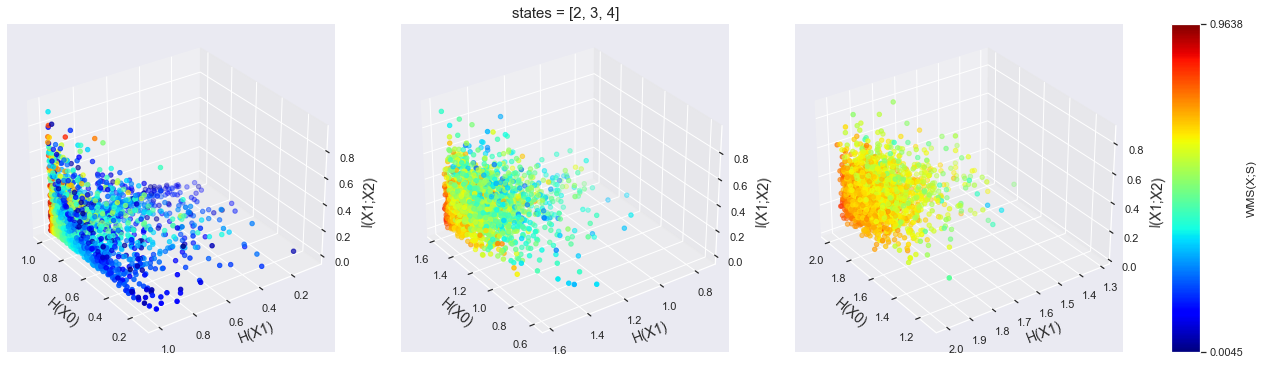

In [7]:
# plots to know what systems there are in the dataset
xcol = 'H(X0)'
ycol = 'H(X1)'
zcol = 'I(X1;X2)'
hue_key='WMS(X;S)'

# 3D Plot
cm = plt.get_cmap("jet")
scatter3d(plot,xcol,ycol,zcol,hue_key,colorsMap=cm,hue=hue_key,states=states)

## syn vs syn upper (2D)

C:\Users\enrik\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]
C:\Users\enrik\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\enrik\Anaconda3\lib\site-packages\ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://p

<AxesSubplot:xlabel='syn_upper', ylabel='syn_info'>

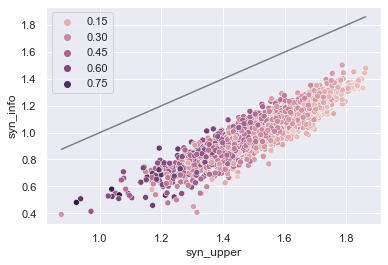

In [126]:
# fig, ax = plt.subplots(figsize=(6,6))        
# sns.scatterplot(data=plot, x=xcol, y=ycol, 
#                 hue=hue_key,
#                 sizes=(10,80),s=100,ax=ax)
# title = dist_type+" input dist states="+str(states)
# plt.title(title,fontsize=14)
# plt.xticks(fontsize=14)
# plt.yticks(fontsize=14)
# plt.xlabel(xcol,fontsize=13)
# plt.ylabel(ycol,fontsize=13)
# plt.show()

plot['WMSmin']=plot['WMS(X;Smin)']*plot['syn_upper']
plot['I(X;Smin)']=plot['WMSmin']+plot['I(Xi;Smin)']
plot['indivnorm']=plot['I(Xi;Smin)']/plot['I(X;Smin)']

# plot['normupper']=plot['syn_upper']/2
sns.scatterplot(data=plot,x='syn_upper',y='syn_info',hue='I(X1;X2)')
sns.lineplot(data=plot,x='syn_upper',y='syn_upper',color='grey')


## RQ 2.3. (Best of fig) in one figure 

<AxesSubplot:xlabel='WMS(X;S)', ylabel='H(Sfound|bestof)'>

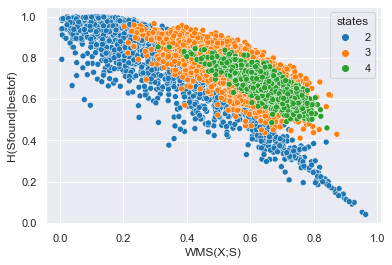

In [8]:
keepkeys = ['WMS(X;S)','syn_info','H(Sfound|bestof)','states']
plot2 = d[keepkeys]
sns.scatterplot(data=plot2,x='WMS(X;S)',y='H(Sfound|bestof)',hue='states',palette='tab10')